In [ ]:
# LAst amended: 17th March, 2025
# RAG with csv files
# USes ollama models, ollama embeddings and chroma vector store

In [ ]:
# References:
#            
#            https://docs.llamaindex.ai/en/stable/examples/embeddings/ollama_embedding/
#            https://docs.llamaindex.ai/en/stable/examples/llm/ollama/
#            https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/
#            https://howaibuildthis.substack.com/p/llamaindex-how-to-use-index-correctly

# Simple RAG (Retrieval-Augmented Generation) System for CSV Files

## Overview

This code implements a basic Retrieval-Augmented Generation (RAG) system for processing and querying CSV documents. The system encodes the document content into a vector store, which can then be queried to retrieve relevant information.

# CSV File Structure and Use Case
The CSV file contains dummy customer data, comprising various attributes like first name, last name, company, etc. This dataset will be utilized for a RAG use case, facilitating the creation of a customer information Q&A system.

## Key Components

1. Loading and spliting csv files.
2. Vector store creation using [Chroma](https://docs.llamaindex.ai/en/stable/examples/vector_stores/ChromaIndexDemo/). See [here](https://github.com/harnalashok/LLMs/blob/main/chromadbExpts%20and%20exports.ipynb) also. Ollama embeddings are used.
3. Query engine setup for querying the processed documents
4. Creating a question and answer over the csv data.

## Method Details

### Document Preprocessing

1. The csv is loaded using LlamaIndex's [PagedCSVReader](https://docs.llamaindex.ai/en/stable/api_reference/readers/file/#llama_index.readers.file.PagedCSVReader)
2. This reader converts each row into a LlamaIndex Document along with the respective column names of the table. No further splitting applied.


### Vector Store Creation

1. Ollama embeddings are used to create vector representations of the text chunks.
2. A Chroma vector store is created from these embeddings for efficient similarity search.

### Query Engine Setup

1. A query engine is configured to fetch the most relevant chunks for a given query then answer the question.

## Benefits of this Approach

1. Scalability: Can handle large documents by processing them in chunks.
2. Flexibility: Easy to adjust parameters like chunk size and number of retrieved results.
3. Efficiency: Utilizes FAISS for fast similarity search in high-dimensional spaces.
4. Integration with Advanced NLP: Uses OpenAI embeddings for state-of-the-art text representation.

## Conclusion

This simple RAG system provides a solid foundation for building more complex information retrieval and question-answering systems. By encoding document content into a searchable vector store, it enables efficient retrieval of relevant information in response to queries. This approach is particularly useful for applications requiring quick access to specific information within a CSV file.

### Imports & Environment Variables 

In [2]:
# 1.0 SimpleDirectoryReader can also load metadata from a dictionary
#     https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader/
from llama_index.core.readers import SimpleDirectoryReader
from llama_index.readers.file import PagedCSVReader

# 1.1 The Settings is a bundle of commonly used resources used 
#     during the indexing and querying stage in a LlamaIndex workflow/application.
from llama_index.core import Settings

# 1.2 If using LocalAI
# https://docs.llamaindex.ai/en/stable/examples/llm/localai/
from llama_index.llms.openai_like import OpenAILike

# 1.3 Ollama related
# https://docs.llamaindex.ai/en/stable/examples/embeddings/ollama_embedding/
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama


# 1.4 Vector store related
import chromadb
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore

# 1.5 Misc
import os
import pandas as pd

/home/ashok/langchain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2.0 Define embedding function

# embed_model = HuggingFaceEmbedding(
#                                     model_name="BAAI/bge-base-en-v1.5"
#                                    )

embed_model= OllamaEmbedding(
                                    model_name="nomic-embed-text",      # Using foundational model may be overkill
                                    base_url="http://localhost:11434",
                                    #dimensions=512,
                                    #ollama_additional_kwargs={"mirostat": 0},
                                  )


In [4]:
# 2.1 Settings can set the global configuration. Local configurations (transformations, LLMs, embedding models).
#     These can be passed directly into the interfaces that make use of them.

Settings.embed_model = embed_model
Settings.llm = Ollama(
                        model="llama3.2:latest",
                        request_timeout=120.0,
                        temperature = 0.0,
                        mirostat = 0)

In [5]:
# 2.2 One can Check its various values:
Settings

_Settings(_llm=Ollama(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7d49628240a0>, system_prompt=None, messages_to_prompt=<function messages_to_prompt at 0x7d4964451750>, completion_to_prompt=<function default_completion_to_prompt at 0x7d49643452d0>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=None, base_url='http://localhost:11434', model='llama3.2:latest', temperature=0.0, context_window=3900, request_timeout=120.0, prompt_key='prompt', json_mode=False, additional_kwargs={}, is_function_calling_model=True, keep_alive=None), _embed_model=OllamaEmbedding(model_name='nomic-embed-text', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7d49628240a0>, num_workers=None, base_url='http://localhost:11434', ollama_additional_kwargs={}), _callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7d49628240a0>, _tokenizer=None, _node_p

In [5]:
# Other configuration can also be set:
"""
For default settings, see:
https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/


from llama_index.core.node_parser import SentenceSplitter

Settings.text_splitter = SentenceSplitter(chunk_size=1024)
Settings.chunk_size = 512             # Default is 1024
Settings.chunk_overlap = 20           # Default is 20
"""


'\nFor default settings, see:\nhttps://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/\n\n\nfrom llama_index.core.node_parser import SentenceSplitter\n\nSettings.text_splitter = SentenceSplitter(chunk_size=1024)\nSettings.chunk_size = 512             # Default is 1024\nSettings.chunk_overlap = 20           # Default is 20\n'

In [112]:
"""
rom llama_index.core.node_parser import SentenceSplitter

Settings.text_splitter = SentenceSplitter(chunk_size=10000)
Settings.chunk_size = 10000             # Default is 1024
Settings.chunk_overlap = 200           # Default is 20
"""

### Load and Process CSV Data as Document

In [6]:
# 3.0 Reading data in pandas
#     It has nothing to do with subsequent analysis/usage

#file_path = ('/home/ashok/Documents/csvrag/data/data.csv') # insert the path of the csv file
file_path = ('/home/ashok/Downloads/csvrag/data/data.csv') # insert the path of the csv file
df = pd.read_csv(file_path)

# 3.1 Preview the csv file
df.head()

,Roll_Number,fullName,Gender,BirthDate,age,MBA CGPA,garduation college,University,Degree,Specialization,...,year when graduation was completed,name of the school attended for class 12,education board for class 12,academic stream chosen in class 12,percentage marks scored in class 12,year when class 12 was completed,name of the school attended for class 10,education board for class 10,percentage marks scored in class 10,year when class 10 was completed
0,1,Amit Sharma,Male,5/14/2002,23,6.69,Vivekananda Institute Of Professional Studies,Guru Gobind Singh Indraprastha University,B.C.A.,Computer Applications,...,2021,Holy Convent School,CBSE,Commerce,79.33,2018,Jaspal Kaur Public School,CBSE,85.16,2018
1,2,Pooja Verma,Female,8/25/1998,27,7.53,Asutosh College,Rajiv Gandhi Proudyogiki Vishwavidyalaya,B.E.,Biology,...,2020,Kishinchand Chellaram College,CBSE,Science,92.60,2015,Delhi Public School,CBSE,89.30,2013
2,3,Rahul Kumar,Female,3/26/2002,23,7.70,St. Xavier'S College,Amity University,B.Com. (Hons.),Finance,...,2022,Delhi Public School,CBSE,Commerce,85.33,2019,Delhi Public School,CBSE,91.67,2017
3,4,Neha Agarwal,Male,8/15/1997,26,5.82,School Of Commerce,Jaypee Institute Of Information Technology,B.Tech,Electronics And Communication Engineering,...,2019,G.A.V. Public School,CBSE,Science (Non-Medical),80.33,2015,Carmel Convent Senior Secondary School,ICSE,72.20,2013
4,5,Rohan Das,Male,8/16/1999,25,6.80,Government Engineering College,Vellore Institute Of Technology,B.A. (Hons.),Economics,...,2021,Summer Fields School,CBSE,Science (Medical),67.60,2017,Salt Lake School,CBSE,83.60,2015


### One way
Directly read csv file

In [7]:
# 4.0 PagedCSVReader displays each row in an LLM-friendly format. Each row as a separate document.
csv_reader = PagedCSVReader()

# 4.1
reader = SimpleDirectoryReader( 
                                input_files=[file_path],
                                file_extractor= {".csv": csv_reader}
                               )

# 4.2
docs = reader.load_data()

In [8]:
# 4.3 Look at Documents
display(len(docs))

print("\n============\n")

display(docs[:2])   # List of Document

500

[Document(id_='23c21661-502a-4e8b-9d4d-42dced527f49', embedding=None, metadata={'file_path': '/home/ashok/Downloads/csvrag/data/data.csv', 'file_name': 'data.csv', 'file_type': 'text/csv', 'file_size': 122011, 'creation_date': '2025-03-18', 'last_modified_date': '2025-03-18'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='Roll_Number: 1\nfullName: Amit Sharma\nGender: Male\nBirthDate: 5/14/2002\nage: 23\nMBA CGPA: 6.69\ngarduation college: Vivekananda Institute Of Professional Studies\nUniversity: Guru Gobind Singh Indraprastha University\nDegree: B.C.A.\nSpecialization: Computer Applications\npercentage marks obtained during graduation:

In [9]:
# 4.4 To read only the text part and not the metadata:

for doc in docs[:1]:
    print(doc.text)

Roll_Number: 1
fullName: Amit Sharma
Gender: Male
BirthDate: 5/14/2002
age: 23
MBA CGPA: 6.69
garduation college: Vivekananda Institute Of Professional Studies
University: Guru Gobind Singh Indraprastha University
Degree: B.C.A.
Specialization: Computer Applications
percentage marks obtained during graduation: 53.83
year when graduation was completed: 2021
name of the school attended for class 12: Holy Convent School
education board for class 12: CBSE
academic stream chosen in class 12: Commerce
percentage marks scored in class 12: 79.33
year when class 12 was completed: 2018
name of the school attended for class 10: Jaspal Kaur Public School
education board for class 10: CBSE
percentage marks scored in class 10: 85.16
year when class 10 was completed: 2018


### IInd way
Using pandas dataframe     
See this [good article](https://blog.stackademic.com/mastering-document-ingestion-in-llamaindex-a-guide-to-integrating-diverse-data-sources-44939ea68617)

In [10]:
# 4.5 To read only specific columns into llama index:
from llama_index.core import Document

# 4.5.1
columns_of_interest = ['Roll_Number', 'fullName' ,'Gender']


# 4.5.2 Convert rows of the CSV into Document objects
documents = [Document(text=row.to_string()) for _, row in df[columns_of_interest].iterrows()]
documents[:2]

[Document(id_='49a8b085-c715-455c-954a-f17a21f78eab', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='Roll_Number              1\nfullName       Amit Sharma\nGender                Male', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}'),
 Document(id_='033f3026-38a5-4d61-8fa6-c6f55d52058c', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='Roll_Number              2\nfullName       Pooja Verma\nGender              Female', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_tem

### StorageContext vs VectorStoreIndex

In LlamaIndex, the StorageContext manages the persistence of data (documents, indices, and vectors), while the VectorStoreIndex is a specific type of index that utilizes a vector store for efficient storage and retrieval of document embeddings.
Here's a more detailed breakdown:
#### 1. Storage Context:     
>•	Purpose:     
The StorageContext is a core abstraction in LlamaIndex that handles the storage and retrieval of data, including documents, indices, and vectors.       
•  •  Components:                 
It contains the underlying BaseDocumentStore (for nodes), BaseIndexStore (for indices), and VectorStore (for vectors).      
•  •  Persisting Data:          
The StorageContext class provides a persist method to save the state of the document store, index store, graph store, and vector stores.    
•  •  Customization:         
LlamaIndex allows you to customize where ingested documents, embedding vectors, and index metadata are stored by using a swappable storage layer.     
•	   
#### 2. VectorStoreIndex:          
>•	Purpose:       
The VectorStoreIndex is a type of index that stores data (documents) as vectors in a vector store, enabling efficient similarity search and retrieval.     
•  •  Default Storage:     
By default, VectorStoreIndex uses an in-memory SimpleVectorStore initialized as part of the default storage context.     
•  •  Vector Stores:     
LlamaIndex supports various vector stores (e.g., Chroma, Pinecone, Weaviate) that can be integrated for storing and querying document embeddings.     
•  •  Integration:     
You can integrate different vector stores to enhance your data management and querying capabilities.     
•  •  Indexing:     
VectorStoreIndex turns text into embeddings using an API from your LLM.      

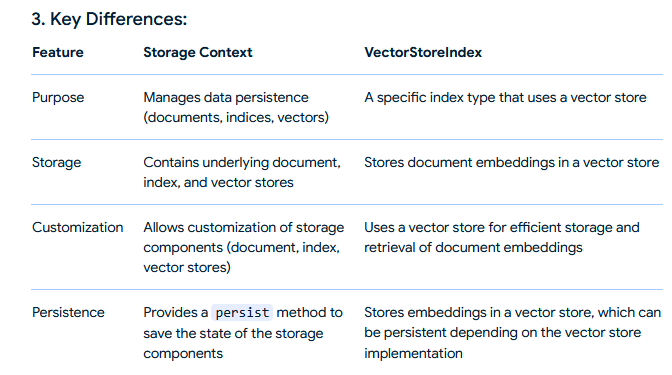

### Vector Store

In [11]:
# 5.0 Create client and a new collection
#     The following is  in-memory database and NOT a persistent collection.
#     chroma_client = chromadb.EphemeralClient()

# 5.1 This creates persistent collection. A folder by name of chromadb
#     is created and below that a chroma.sqlite3 database exists:

chroma_client = chromadb.PersistentClient(path="/home/ashok/Documents/chroma_db")

In [13]:
# 5.2 Check if collection exists. If so delete it.
#     Collections are the grouping mechanism for embeddings, documents, and metadata.
#     Chromadb can have multiple collections

if 'datastore' in chroma_client.list_collections():
    chroma_client.delete_collection("datastore")
    chroma_collection = chroma_client.create_collection("datastore")  
else:
    # Create collection afresh
    chroma_collection = chroma_client.create_collection("datastore")   

# 5.3 Get collection information:
chroma_collection    

Collection(name=datastore)

In [14]:
# 5.4 Some chroma_client related methods:
print("\nNumber of collections in chromadb")
display(chroma_client.count_collections())
print("\nList of collections in chromadb")
display(chroma_client.list_collections())
print("\nNumber of records in a collection")
display(chroma_collection.count())


Number of collections in chromadb


2


List of collections in chromadb


['quickstart', 'datastore']


Number of records in a collection


0

In [15]:
# 6.0 Set up a blank ChromaVectorStore and load in data
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# 6.1
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [16]:
%%time

# 6.2 Takes docs and storage context:
#     Repeating this operation, doubles the number of vectors/records in the collection

index = VectorStoreIndex.from_documents(
                                         docs,
                                         storage_context=storage_context,
                                         show_progress= True                 # Show progress bar
                                        )

Generating embeddings: 100%|█████████████████| 500/500 [00:04<00:00, 101.91it/s]


CPU times: user 1.06 s, sys: 101 ms, total: 1.16 s
Wall time: 5.44 s


In [17]:
# 6.3
print("\nNumber of records in a collection")
display(chroma_collection.count())


Number of records in a collection


500

In [44]:
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

message_templates = [
    ChatMessage(content="You are an expert system.", role=MessageRole.SYSTEM),
    ChatMessage(
        content="Generate a short story about {topic}",
        role=MessageRole.USER,
    ),
]
chat_template = ChatPromptTemplate(message_templates=message_templates)

# you can create message prompts (for chat API)
messages = chat_template.format_messages(topic=...)

# or easily convert to text prompt (for completion API)
# prompt = chat_template.format(topic=...)



# Update the prompts of your query engine
# 7.0 Query Data
query_engine = index.as_query_engine()
query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": formatted_prompt }
)

### Create Simple Query Engine

In [18]:
# 7.0 Query Data
query_engine = index.as_query_engine()

In [19]:
7.1
response = query_engine.query("Give me all details of the student with Roll Number 1 and full name as 'Amit Sharma' .")
#response = query_engine.query("Give me full names of all students in the data")

In [20]:
# 7.2
print(response)

Roll_Number: 1
fullName: Amit Sharma
Gender: Male
BirthDate: 5/14/2002
age: 23
MBA CGPA: 6.69
garduation college: Vivekananda Institute Of Professional Studies
University: Guru Gobind Singh Indraprastha University
Degree: B.C.A.
Specialization: Computer Applications
percentage marks obtained during graduation: 53.83
year when graduation was completed: 2021
name of the school attended for class 12: Holy Convent School
education board for class 12: CBSE
academic stream chosen in class 12: Commerce
percentage marks scored in class 12: 79.33
year when class 12 was completed: 2018
name of the school attended for class 10: Jaspal Kaur Public School
education board for class 10: CBSE
percentage marks scored in class 10: 85.16
year when class 10 was completed: 2018


## Completion prompt vs chat prompt

The main difference between completion and chat prompts lies in their structure and intended use: completion prompts are single strings for text generation, while chat prompts are lists of messages (with roles like "system," "user," and "assistant") designed for conversational AI interactions.   
Here's a more detailed breakdown:
**Completion Prompts:**      

>**Structure**: A single string of text, often used for tasks like generating text, completing sentences, or translating.       
>**Example**: "The quick brown fox jumps over..."        
>**Use Cases**: Text generation, code completion, and other tasks where the AI needs to extend or complete a given input.       
>**API**: Uses the legacy /completions endpoint.       

**Chat Prompts:**     
>**Structure**: A list of messages, each with a "role" (e.g., "system," "user," "assistant") and "content".     
>**Example**
><pre>
  [
      {"role": "system", "content": "You are a helpful assistant."},
      {"role": "user", "content": "What is the capital of France?"},
      {"role": "assistant", "content": "The capital of France is Paris."}
    ]
    
</pre>
>**Use Cases**: Conversational AI, chatbots, and other applications where the AI needs to engage in a dialogue.      
>**API**: Uses the /chat/completions endpoint.      
>**Flexibility**: Offers more control and flexibility by allowing you to define the system's role, incorporate previous responses, and set the user's prompt     

## Using prompt in queries
Defining a custom prompt is as simple as creating a format string     
See this [link](https://docs.llamaindex.ai/en/stable/module_guides/models/prompts/usage_pattern/)  and this [link](https://community.llamaindex.ai/how-do-i-add-a-custom-prompt-to-my-query-engine-i-want-to-pass-in-a-custom-promptlets-LKz2xGw8KCzv)

In [22]:
# 8.0
from llama_index.core import PromptTemplate

# 8.1 Define your custom prompt with the new variable
custom_prompt_str = (
                      "You are an expert Q&A system that is trusted around the world.\n"
                      "Your description as an agent is as follows: \n"
                      "{{chatbot_description}}\n"
                             "Always answer the query using the provided context information, and not prior knowledge.\n"
                      "Some rules to follow:\n"
                          "Never directly reference the given context in your answer.\n"
                          "Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.\n"
                      "\n"
                     "Context information is below.\n"
                     "---------------------\n"
                     "{{context_str}}\n"
                     "---------------------\n"
                        "Given the context information and not prior knowledge, answer the query.\n"
                        "Query: {{query_str}}\n"
                        "Answer: "
                  )


# 8.2 Create a PromptTemplate with your custom prompt
custom_prompt = PromptTemplate(custom_prompt_str)


# 8.3 Update the prompts of your query engine
query_engine.update_prompts(
                              {"response_synthesizer:text_qa_template": custom_prompt}
                           )

# 8.4 Now you can make a query with your query engine
query_str = "Give me CGPA score of student with Roll Number 1 and full name as 'Amit Sharma' ."
response = query_engine.query(query_str)

# 8.5 Print the response
print(str(response))

The CGPA score for Amit Sharma is 6.69.


## Chatting with data

In [30]:
# 9.0
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

# 9.1 An ambiguous SYSTEM message
message_templates = [
                     ChatMessage(content="You are an expert system.", role=MessageRole.SYSTEM),
                     ChatMessage(
                                 content="{query_str}",
                                 role=MessageRole.USER,
                               ),
                    ]
# 9.2
chat_template = ChatPromptTemplate(message_templates=message_templates)


# 9.3
query_str = "Give me all details of the student with Roll Number 1 and full name as 'Amit Sharma' ."


# 9.4 Query Data with a general query without reference to any document
query_engine = index.as_query_engine()
query_engine.update_prompts(
                            {"response_synthesizer:text_qa_template": chat_template }
                            )


#prompt = chat_template.format(topic=query_str)
# 9.5
response = query_engine.query(query_str)
print(str(response))

I don't have any information about a specific student with roll number 1 and full name as "Amit Sharma". I'm a large language model, I don't have access to personal data or records of individual students. My training data is general knowledge and doesn't include specific details about individuals.

If you're looking for information about a particular student, it's likely that the information would be stored in a school or university database, or perhaps in a student information system (SIS). I wouldn't be able to provide you with any details without more context or access to those systems.


In [25]:
# 10.0 A better question

chat_engine = index.as_chat_engine(chat_mode="condense_question", verbose=True)
response = chat_engine.chat("Give me CGPA score of student with Roll Number 1 and full name as 'Amit Sharma'")
print(str(response))

In [28]:
# 10.1 Follow up query
response = chat_engine.chat("What was the name of the school he attended for class 12?")
print(str(response))

Querying with: What is the name of the school that Amit Sharma, a student with a CGPA score of 6.69 and roll number 1, attended for his class 12 exams?
Holy Convent School


### Define SYSTEM and USE prompt separately

In [32]:
# 11.0
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole


# 8.1 Define your SYSTEM prompt with the new variable
custom_prompt_str = (
                      "You are an expert Q&A system that is trusted around the world.\n"
                      "Your description as an agent is as follows: \n"
                      "{{chatbot_description}}\n"
                             "Always answer the query using the provided context information, and not prior knowledge.\n"
                      "Some rules to follow:\n"
                          "Never directly reference the given context in your answer.\n"
                          "Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.\n"
                      "\n"
                     "Context information is below.\n"
                     "---------------------\n"
                     "{{context_str}}\n"
                     "---------------------\n"
                        "Given the context information and not prior knowledge, answer the query.\n"
                        "Query: {{query_str}}\n"
                        "Answer: "
                  )


# 8.2 Create a PromptTemplate with your custom prompt
custom_prompt = PromptTemplate(custom_prompt_str)

message_templates = [
                     ChatMessage(content=custom_prompt_str, role=MessageRole.SYSTEM),
                     ChatMessage(
                                 content="Given the context information and not prior knowledge, answer the query: {query_str}",
                                 role=MessageRole.USER,
                               ),
                    ]

chat_template = ChatPromptTemplate(message_templates= message_templates )

# you can create message prompts (for chat API)
#messages = chat_template.format_messages(topic= "Cat and mouse")

# or easily convert to text prompt (for completion API)
query_str = "Give me all details of the student with Roll Number 1 and full name as 'Amit Sharma' ."
#prompt = chat_template.format(topic=query_str)
#chat_template = ChatPromptTemplate(message_templates=message_templates)


# Update the prompts of your query engine
# 7.0 Query Data
query_engine = index.as_query_engine()
query_engine.update_prompts(
                            {"response_synthesizer:text_qa_template": chat_template }
                            )


#prompt = chat_template.format(topic=query_str)

response = query_engine.query(query_str)
print(str(response))

Roll Number 1 belongs to Amit Sharma. He is a male student born on May 14, 2002. His age is 23 years old. Amit Sharma graduated from Vivekananda Institute Of Professional Studies with a degree in B.C.A. under the Computer Applications specialization. During his graduation, he scored 53.83% marks and completed his studies in the year 2021. In class 12, Amit attended Holy Convent School, achieved 79.33% marks, and graduated in Commerce stream. He also attended Jaspal Kaur Public School for class 10, scoring 85.16% marks, and completed his class 10 education in 2018.


In [ ]:
##################